##### Download, normalize and split vol cube data into train/test datasets

In [1]:
import sys
sys.path.append('../..')  # to go to the main folder of the whole project

from src.data.vol.get_vol_cube_tenors_strikes_dates import get_vol_cube_tenors_strikes_dates
data, uniq_opt_tenors, uniq_swap_tenors, uniq_strikes, dates = get_vol_cube_tenors_strikes_dates()

# Normalize data
from src.data.vol.normalizer import Normalizer
normalizer = Normalizer()
data_norm = normalizer.normalize(data)

# Split train and test datasets
seed = 0 # other seeds provides the same result
from src.utils.get_train_test_datasets import get_train_test_datasets
data_norm_train, dates_train, data_norm_test, dates_test = get_train_test_datasets(data_norm,
                                                                                   dates,
                                                                                    seed=seed,
                                                                                    train_ratio=0.8)
data_train = normalizer.denormalize(data_norm_train)
data_test = normalizer.denormalize(data_norm_test)

##### Load the saved model and its history from the file

In [2]:
from src.utils.load_model_and_history import load_model_and_history

NAME = 'vol_cube_vae_van_2latd_400_200_200_100_3000ep_bat16_2e-06_seed0'
vae, history = load_model_and_history(NAME,
                                      data_type='vol')

c:\Users\alexi\Documents\All\ETH_UZH\MasterThesis\_MT_Vol_cube\code_my\autoencoder_library\venv\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


##### Check robustness

We select random z value, then shift z by 0.01 in 8 directions and calculate the change in volatility cube 8 times. We find the maximum change in volatility cube among all data points and among 8 shifts. We do this procedure for 1000 randomly generated z values (it takes 10 minutes)

In [3]:
import numpy as np
from src.visualization.vol.vol_cube_grids import vol_cube_grids
strikes = ['ATM-100bp', 'ATM-50bp', 'ATM', 'ATM+50bp', 'ATM+100bp']  # graphs only for these strikes

N = 1_000
SHIFT = 0.01
shifts = [[-SHIFT, -SHIFT], [-SHIFT, 0], [-SHIFT, SHIFT], \
          [0, -SHIFT], [0, SHIFT], \
          [SHIFT, -SHIFT], [SHIFT, 0], [SHIFT, SHIFT]]  # shifts in 8 direction from the central point
mean = np.zeros(2)
cov = np.eye(2)

mse_worst = 0
diff_worst = None

for i in range(N):
    # Create vol cube from the random point
    np.random.seed(i)
    z_initial = np.random.multivariate_normal(mean, cov, 1)
    gen_vol_cube_initial = normalizer.denormalize(vae.decoder.predict(np.array(z_initial), verbose=0))
    # Create 8 vol cubes moving from the random point in 8 directions
    for dx_dy in shifts:
        np.random.seed(i)   
        z = z_initial + dx_dy
        gen_vol_cube = normalizer.denormalize(vae.decoder.predict(np.array(z), verbose=0))
        diff = gen_vol_cube - gen_vol_cube_initial
        mse = abs(diff).max()
        if mse > mse_worst:
            mse_worst = mse
            diff_worst = diff

##### The maximum shift in volatility cube over all data points and all test dates

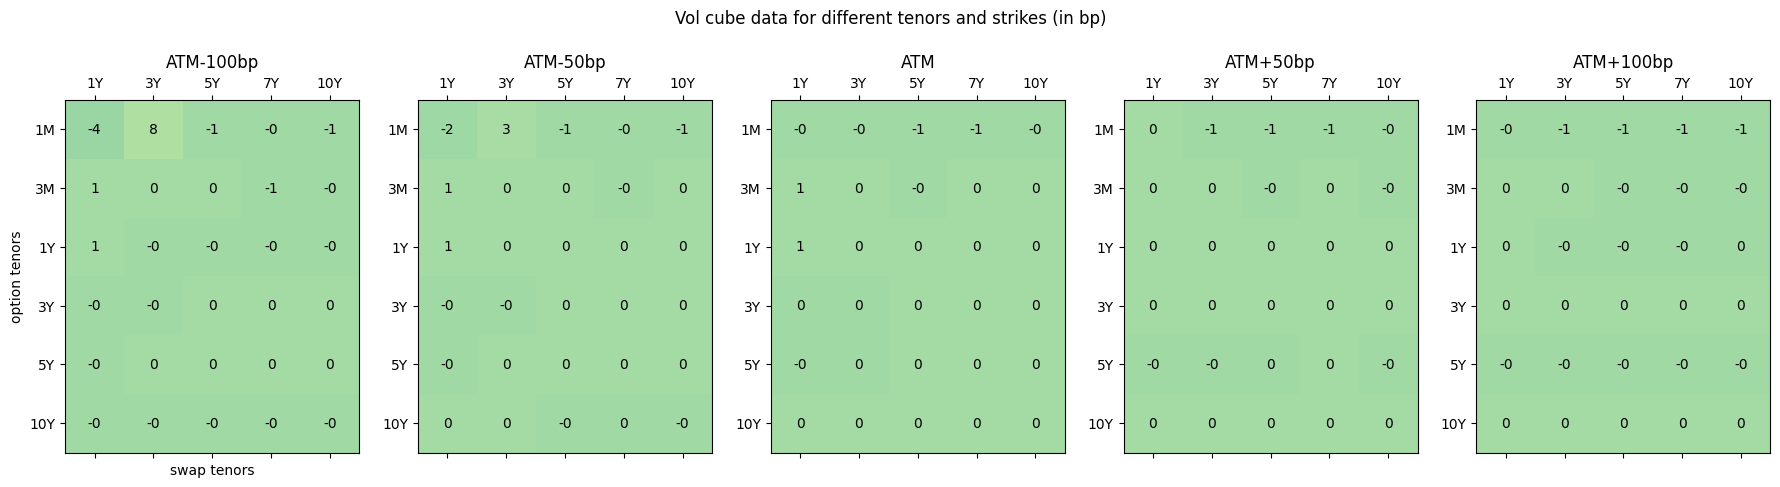

In [4]:
vol_cube_grids(data=diff_worst[0],
                x_labels=uniq_swap_tenors,
                y_labels=uniq_opt_tenors,
                uniq_strikes=uniq_strikes,
                strikes=strikes,
                save_name=NAME)